In [1]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import tqdm
import torch.nn as nn

In [71]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [72]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
classes = os.listdir('Data/images_original')
classes.sort()
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

images = []
labels = []
for i, cls_name in enumerate(classes):
    path = os.path.join('Data/images_original', cls_name)
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)
        images.append(img)
        labels.append(i)
images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)
print(images.shape, labels.shape)

torch.Size([999, 3, 256, 256]) torch.Size([999])


In [74]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [75]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=42)
print(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape)

torch.Size([799, 3, 256, 256]) torch.Size([200, 3, 256, 256]) torch.Size([799]) torch.Size([200])


Text(0.5, 1.0, 'jazz')

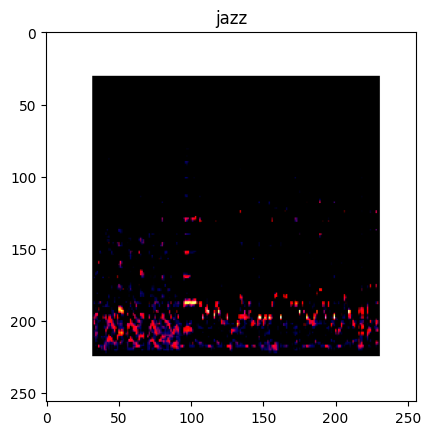

In [76]:
# print a image from the dataset
import matplotlib.pyplot as plt

plt.imshow(train_images[110].cpu().numpy().transpose(1, 2, 0))
plt.title(idx_to_class[train_labels[110].item()])

In [77]:

class MusicDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [78]:
dataset_train = MusicDataset(train_images, train_labels)
DataLoader_train = DataLoader(dataset_train, batch_size=50, shuffle=True)

In [79]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [87]:
from torchvision.models import squeezenet1_1
model = squeezenet1_1(pretrained=True)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [92]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)

model = model.to(device)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [93]:
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
num_epochs = 300
patience = 15  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to keep track of the number of epochs without improvement
log = {}


for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0
    for images, labels in tqdm.tqdm(DataLoader_train):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        pred = torch.argmax(test_outputs, dim=1)
        acc = (pred == test_labels).sum().item() / len(test_labels)

        # save the loss and accuracy
        log[epoch] = {'loss_train': loss.item(), 'loss_val': test_loss.item(), 'accuracy_val': acc}
        print(f'Epoch {epoch}, loss_train: {loss.item() / len(DataLoader_train)}, loss_val: {test_loss.item()}, accuracy_val: {acc}')

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'find-tuned-squeezenet.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

100%|██████████| 16/16 [00:00<00:00, 52.99it/s]


Epoch 0, loss_train: 0.12416445463895798, loss_val: 2.0200884342193604, accuracy_val: 0.275


100%|██████████| 16/16 [00:00<00:00, 53.11it/s]


Epoch 1, loss_train: 0.10643300414085388, loss_val: 1.7283004522323608, accuracy_val: 0.455


100%|██████████| 16/16 [00:00<00:00, 52.20it/s]


Epoch 2, loss_train: 0.09018762409687042, loss_val: 1.5840150117874146, accuracy_val: 0.475


100%|██████████| 16/16 [00:00<00:00, 52.18it/s]


Epoch 3, loss_train: 0.0931943953037262, loss_val: 1.4433772563934326, accuracy_val: 0.5


100%|██████████| 16/16 [00:00<00:00, 52.38it/s]


Epoch 4, loss_train: 0.08004364371299744, loss_val: 1.3857927322387695, accuracy_val: 0.565


100%|██████████| 16/16 [00:00<00:00, 52.35it/s]


Epoch 5, loss_train: 0.08310551196336746, loss_val: 1.3514965772628784, accuracy_val: 0.53


100%|██████████| 16/16 [00:00<00:00, 52.93it/s]


Epoch 6, loss_train: 0.08129201829433441, loss_val: 1.2697299718856812, accuracy_val: 0.59


100%|██████████| 16/16 [00:00<00:00, 52.26it/s]


Epoch 7, loss_train: 0.0742608979344368, loss_val: 1.2232805490493774, accuracy_val: 0.6


100%|██████████| 16/16 [00:00<00:00, 51.57it/s]


Epoch 8, loss_train: 0.06903985142707825, loss_val: 1.2494025230407715, accuracy_val: 0.55


100%|██████████| 16/16 [00:00<00:00, 52.01it/s]


Epoch 9, loss_train: 0.07436389476060867, loss_val: 1.170832872390747, accuracy_val: 0.6


100%|██████████| 16/16 [00:00<00:00, 52.65it/s]


Epoch 10, loss_train: 0.06815861165523529, loss_val: 1.1899926662445068, accuracy_val: 0.555


100%|██████████| 16/16 [00:00<00:00, 52.52it/s]


Epoch 11, loss_train: 0.07175420969724655, loss_val: 1.174034833908081, accuracy_val: 0.58


100%|██████████| 16/16 [00:00<00:00, 52.15it/s]


Epoch 12, loss_train: 0.054589416831731796, loss_val: 1.119057059288025, accuracy_val: 0.605


100%|██████████| 16/16 [00:00<00:00, 52.07it/s]


Epoch 13, loss_train: 0.07673822343349457, loss_val: 1.114518642425537, accuracy_val: 0.6


100%|██████████| 16/16 [00:00<00:00, 51.83it/s]


Epoch 14, loss_train: 0.056054119020700455, loss_val: 1.1885881423950195, accuracy_val: 0.605


100%|██████████| 16/16 [00:00<00:00, 51.44it/s]


Epoch 15, loss_train: 0.0737953633069992, loss_val: 1.1107020378112793, accuracy_val: 0.595


100%|██████████| 16/16 [00:00<00:00, 51.86it/s]


Epoch 16, loss_train: 0.058297064155340195, loss_val: 1.1193195581436157, accuracy_val: 0.6


100%|██████████| 16/16 [00:00<00:00, 51.92it/s]


Epoch 17, loss_train: 0.05438948795199394, loss_val: 1.1124988794326782, accuracy_val: 0.62


100%|██████████| 16/16 [00:00<00:00, 51.42it/s]


Epoch 18, loss_train: 0.055305659770965576, loss_val: 1.0916880369186401, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.79it/s]


Epoch 19, loss_train: 0.06583883613348007, loss_val: 1.0677317380905151, accuracy_val: 0.595


100%|██████████| 16/16 [00:00<00:00, 51.71it/s]


Epoch 20, loss_train: 0.048212986439466476, loss_val: 1.069949746131897, accuracy_val: 0.615


100%|██████████| 16/16 [00:00<00:00, 50.79it/s]


Epoch 21, loss_train: 0.0622420571744442, loss_val: 1.0780938863754272, accuracy_val: 0.625


100%|██████████| 16/16 [00:00<00:00, 51.54it/s]


Epoch 22, loss_train: 0.06695714592933655, loss_val: 1.0920382738113403, accuracy_val: 0.61


100%|██████████| 16/16 [00:00<00:00, 51.23it/s]


Epoch 23, loss_train: 0.0640178769826889, loss_val: 1.051827073097229, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 52.07it/s]


Epoch 24, loss_train: 0.05444328486919403, loss_val: 1.0290162563323975, accuracy_val: 0.62


100%|██████████| 16/16 [00:00<00:00, 52.16it/s]


Epoch 25, loss_train: 0.06307078152894974, loss_val: 1.038282036781311, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 50.74it/s]


Epoch 26, loss_train: 0.05282217636704445, loss_val: 1.0514127016067505, accuracy_val: 0.62


100%|██████████| 16/16 [00:00<00:00, 51.02it/s]


Epoch 27, loss_train: 0.05517624318599701, loss_val: 1.0355225801467896, accuracy_val: 0.615


100%|██████████| 16/16 [00:00<00:00, 51.19it/s]


Epoch 28, loss_train: 0.05062290281057358, loss_val: 1.033117651939392, accuracy_val: 0.615


100%|██████████| 16/16 [00:00<00:00, 51.43it/s]


Epoch 29, loss_train: 0.04033927991986275, loss_val: 1.0498225688934326, accuracy_val: 0.62


100%|██████████| 16/16 [00:00<00:00, 52.07it/s]


Epoch 30, loss_train: 0.060398899018764496, loss_val: 1.0733380317687988, accuracy_val: 0.62


100%|██████████| 16/16 [00:00<00:00, 51.32it/s]


Epoch 31, loss_train: 0.049534816294908524, loss_val: 1.0568912029266357, accuracy_val: 0.625


100%|██████████| 16/16 [00:00<00:00, 51.40it/s]


Epoch 32, loss_train: 0.06152595952153206, loss_val: 1.0080407857894897, accuracy_val: 0.62


100%|██████████| 16/16 [00:00<00:00, 52.40it/s]


Epoch 33, loss_train: 0.056362517178058624, loss_val: 0.999158501625061, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 51.98it/s]


Epoch 34, loss_train: 0.04105193167924881, loss_val: 1.0200893878936768, accuracy_val: 0.615


100%|██████████| 16/16 [00:00<00:00, 51.67it/s]


Epoch 35, loss_train: 0.06141703948378563, loss_val: 1.0266830921173096, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 50.92it/s]


Epoch 36, loss_train: 0.05313534662127495, loss_val: 1.0113823413848877, accuracy_val: 0.635


100%|██████████| 16/16 [00:00<00:00, 51.59it/s]


Epoch 37, loss_train: 0.049677614122629166, loss_val: 1.006187915802002, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 50.68it/s]


Epoch 38, loss_train: 0.051464591175317764, loss_val: 1.012698769569397, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 51.01it/s]


Epoch 39, loss_train: 0.05073798447847366, loss_val: 1.0030531883239746, accuracy_val: 0.675


100%|██████████| 16/16 [00:00<00:00, 51.33it/s]


Epoch 40, loss_train: 0.05558285117149353, loss_val: 1.0112289190292358, accuracy_val: 0.61


100%|██████████| 16/16 [00:00<00:00, 51.24it/s]


Epoch 41, loss_train: 0.04150479659438133, loss_val: 1.0024383068084717, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.47it/s]


Epoch 42, loss_train: 0.04720021411776543, loss_val: 0.9775041341781616, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 51.01it/s]


Epoch 43, loss_train: 0.04215295612812042, loss_val: 1.0002655982971191, accuracy_val: 0.635


100%|██████████| 16/16 [00:00<00:00, 51.70it/s]


Epoch 44, loss_train: 0.03407106548547745, loss_val: 0.9832883477210999, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.29it/s]


Epoch 45, loss_train: 0.034395914524793625, loss_val: 1.0025734901428223, accuracy_val: 0.61


100%|██████████| 16/16 [00:00<00:00, 51.59it/s]


Epoch 46, loss_train: 0.0381116084754467, loss_val: 0.9870092868804932, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 51.38it/s]


Epoch 47, loss_train: 0.04824572801589966, loss_val: 0.9836768507957458, accuracy_val: 0.635


100%|██████████| 16/16 [00:00<00:00, 51.11it/s]


Epoch 48, loss_train: 0.04145412892103195, loss_val: 0.9995643496513367, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.27it/s]


Epoch 49, loss_train: 0.03994608670473099, loss_val: 0.9851011633872986, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.12it/s]


Epoch 50, loss_train: 0.05017968639731407, loss_val: 0.9979233741760254, accuracy_val: 0.625


100%|██████████| 16/16 [00:00<00:00, 51.51it/s]


Epoch 51, loss_train: 0.03705645725131035, loss_val: 0.9620940685272217, accuracy_val: 0.67


100%|██████████| 16/16 [00:00<00:00, 51.61it/s]


Epoch 52, loss_train: 0.05149601027369499, loss_val: 0.9993413686752319, accuracy_val: 0.635


100%|██████████| 16/16 [00:00<00:00, 51.45it/s]


Epoch 53, loss_train: 0.045420680195093155, loss_val: 0.9837363958358765, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 50.51it/s]


Epoch 54, loss_train: 0.050813473761081696, loss_val: 0.9872961640357971, accuracy_val: 0.615


100%|██████████| 16/16 [00:00<00:00, 50.28it/s]


Epoch 55, loss_train: 0.04194866493344307, loss_val: 0.9735314846038818, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 50.56it/s]


Epoch 56, loss_train: 0.032154716551303864, loss_val: 0.9706884026527405, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 50.78it/s]


Epoch 57, loss_train: 0.037567466497421265, loss_val: 0.9867725968360901, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.33it/s]


Epoch 58, loss_train: 0.04225572198629379, loss_val: 0.9744547009468079, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 51.24it/s]


Epoch 59, loss_train: 0.04182150587439537, loss_val: 0.9726440906524658, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 51.42it/s]


Epoch 60, loss_train: 0.04042759910225868, loss_val: 0.9609019756317139, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 52.20it/s]


Epoch 61, loss_train: 0.025671618059277534, loss_val: 0.9624581336975098, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 52.43it/s]


Epoch 62, loss_train: 0.046692024916410446, loss_val: 0.9824455380439758, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.70it/s]


Epoch 63, loss_train: 0.03927375748753548, loss_val: 0.9547723531723022, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 52.16it/s]


Epoch 64, loss_train: 0.04081340134143829, loss_val: 0.9980986714363098, accuracy_val: 0.625


100%|██████████| 16/16 [00:00<00:00, 51.82it/s]


Epoch 65, loss_train: 0.03907516971230507, loss_val: 0.9535956382751465, accuracy_val: 0.635


100%|██████████| 16/16 [00:00<00:00, 51.84it/s]


Epoch 66, loss_train: 0.0422605462372303, loss_val: 0.9667509198188782, accuracy_val: 0.68


100%|██████████| 16/16 [00:00<00:00, 51.53it/s]


Epoch 67, loss_train: 0.03858339786529541, loss_val: 0.9625452160835266, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 51.05it/s]


Epoch 68, loss_train: 0.048904869705438614, loss_val: 0.9681992530822754, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.80it/s]


Epoch 69, loss_train: 0.03724806010723114, loss_val: 0.9878895282745361, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 51.25it/s]


Epoch 70, loss_train: 0.04282412305474281, loss_val: 0.950439453125, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 52.07it/s]


Epoch 71, loss_train: 0.04468587040901184, loss_val: 0.9541282057762146, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.50it/s]


Epoch 72, loss_train: 0.04288125038146973, loss_val: 0.9953173995018005, accuracy_val: 0.615


100%|██████████| 16/16 [00:00<00:00, 51.35it/s]


Epoch 73, loss_train: 0.04198941960930824, loss_val: 0.9450765252113342, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 50.59it/s]


Epoch 74, loss_train: 0.031170587986707687, loss_val: 0.9639968276023865, accuracy_val: 0.635


100%|██████████| 16/16 [00:00<00:00, 50.81it/s]


Epoch 75, loss_train: 0.036330003291368484, loss_val: 0.9529130458831787, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 51.01it/s]


Epoch 76, loss_train: 0.030324267223477364, loss_val: 0.9712865352630615, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 51.91it/s]


Epoch 77, loss_train: 0.04338614270091057, loss_val: 0.9413372874259949, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 51.75it/s]


Epoch 78, loss_train: 0.038804732263088226, loss_val: 0.9815240502357483, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 51.91it/s]


Epoch 79, loss_train: 0.04054805263876915, loss_val: 0.9514903426170349, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 51.21it/s]


Epoch 80, loss_train: 0.03928181529045105, loss_val: 0.9691414833068848, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 51.62it/s]


Epoch 81, loss_train: 0.02558918297290802, loss_val: 0.9807286262512207, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.58it/s]


Epoch 82, loss_train: 0.04045427590608597, loss_val: 0.9602239727973938, accuracy_val: 0.665


100%|██████████| 16/16 [00:00<00:00, 51.60it/s]


Epoch 83, loss_train: 0.035587385296821594, loss_val: 0.9941950440406799, accuracy_val: 0.64


100%|██████████| 16/16 [00:00<00:00, 51.73it/s]


Epoch 84, loss_train: 0.0376124233007431, loss_val: 0.9776557087898254, accuracy_val: 0.67


100%|██████████| 16/16 [00:00<00:00, 51.53it/s]


Epoch 85, loss_train: 0.04001448675990105, loss_val: 0.9551538228988647, accuracy_val: 0.65


100%|██████████| 16/16 [00:00<00:00, 51.17it/s]


Epoch 86, loss_train: 0.02659463696181774, loss_val: 0.9555157423019409, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.22it/s]


Epoch 87, loss_train: 0.024946313351392746, loss_val: 0.9546732306480408, accuracy_val: 0.645


100%|██████████| 16/16 [00:00<00:00, 51.64it/s]


Epoch 88, loss_train: 0.02392059750854969, loss_val: 0.9544803500175476, accuracy_val: 0.66


100%|██████████| 16/16 [00:00<00:00, 51.72it/s]


Epoch 89, loss_train: 0.03941243141889572, loss_val: 0.960966944694519, accuracy_val: 0.675


100%|██████████| 16/16 [00:00<00:00, 51.56it/s]


Epoch 90, loss_train: 0.024348393082618713, loss_val: 0.9604704976081848, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.93it/s]


Epoch 91, loss_train: 0.034178733825683594, loss_val: 0.9588351249694824, accuracy_val: 0.63


100%|██████████| 16/16 [00:00<00:00, 51.99it/s]


Epoch 92, loss_train: 0.03457396477460861, loss_val: 0.9595862030982971, accuracy_val: 0.655
Early stopping at epoch 92


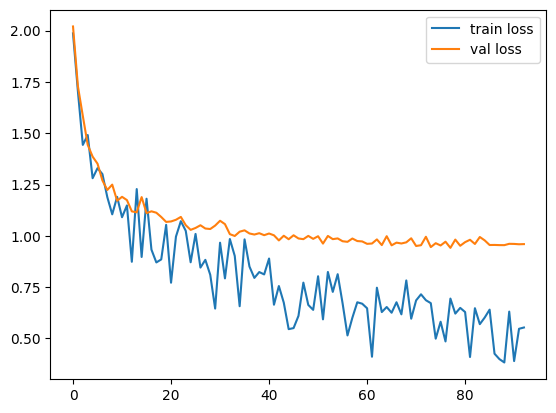

In [94]:
# draw the loss and accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot([log[k]['loss_train'] for k in log], label='train loss')
plt.plot([log[k]['loss_val'] for k in log], label='val loss')
plt.legend()
plt.show()


In [95]:
# load the model
model.load_state_dict(torch.load('find-tuned-squeezenet.pth'))

# test the model
model.eval()
from sklearn.metrics import classification_report

print(classification_report(test_labels.detach().cpu().numpy(), torch.argmax(model(test_images), dim=1).detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64        21
           1       0.80      1.00      0.89        12
           2       0.60      0.50      0.55        24
           3       0.65      0.68      0.67        22
           4       0.71      0.80      0.75        15
           5       0.81      0.78      0.79        27
           6       0.94      0.94      0.94        18
           7       0.53      0.47      0.50        19
           8       0.59      0.59      0.59        22
           9       0.42      0.40      0.41        20

    accuracy                           0.67       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.66      0.67      0.66       200

